In [1]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch
import matplotlib.pyplot as plt

In [4]:
# training data
data_URL = '/home/raychiu/Dataset/shakespeare_train.txt'
with open(data_URL, 'r') as f:
    text = f.read()

vocab = set(text)
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))
int_to_vocab[67] = 'unknown_alphabet'
train_encode = np.array([vocab_to_int[c] for c in text], dtype=np.int32)

# validation data
data_URL = '/home/raychiu/Dataset/shakespeare_valid.txt'
with open(data_URL, 'r') as f:
    text = f.read()

valid_encode = np.array([vocab_to_int[c] for c in text], dtype=np.int32)


# -------------------------------------------------------------#
# Divide data into mini-batches
# -------------------------------------------------------------#
def get_batches(arr, n_seqs, n_steps):
    
    '''
    arr: data to be divided
    n_seqs: batch-size, # of input sequences
    n_steps: timestep, # of characters in a input sequences
    '''
    
    batch_size = n_seqs * n_steps
    n_batches = int(len(arr) / batch_size)
    arr = arr[:batch_size * n_batches]
    arr = arr.reshape((n_seqs, -1))
    
    for n in range(0, arr.shape[1], n_steps):
        x = arr[:, n:n+n_steps]
        y = np.zeros_like(x)
        y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
        yield x, y

# Function above define a generator, call next() to get one mini-batch
batch_size = 10
timesteps = 50
train_batches = get_batches(train_encode, batch_size, timesteps)
x, y = next(train_batches)

In [50]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn=nn.RNN(
            input_size = 68,
            hidden_size = 128,
            num_layers = 1,
            batch_first = True,
        )
        self.out = nn.Linear(128,68)
        
    def forward(self, x, hidden):
        output, hidden = self.rnn(x, hidden)
        outs = []
        for time_step in range(output.size(1)):
            outs.append(self.out(output[:,time_step,:]))
        return torch.stack(outs, dim = 1), hidden

In [51]:
net = RNN()
print(net)

RNN(
  (rnn): RNN(68, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=68, bias=True)
)


In [ ]:
learning_rate = 0.001
batch_size = 64
num_steps = 50
rnn = RNN().cuda()
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

loss_train = []
loss_test = []
for epoch in range(20):
    hidden = None
    step_loss = []
    for x, y in get_batches(train_encode, batch_size, num_steps): 
        train_x = np.zeros((batch_size,num_steps,68))
        for i in range(batch_size):
            for j in range(num_steps):
                train_x[i, j, x[i,j]] = 1
        train_x = Variable(torch.Tensor(train_x)).cuda()
        train_y = Variable(torch.LongTensor(y)).cuda()
        output, hidden = rnn(train_x, hidden)
        # view as reshape
        output = output.view(-1,68)
        #hidden_t, hidden_t1 = hidden[0],hidden[1]
        hidden = Variable(hidden.data)#_t,hidden_t1))
        hidden = hidden.cuda()
        train_y = train_y.view(-1)
        loss = criterion(output, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # variable to numpy
        step_loss.append(loss.data.cpu().numpy())
    loss_train.append(np.mean(step_loss))
    
    hidden = None
    step_loss = []
    for x, y in get_batches(valid_encode, batch_size, num_steps):        
        test_x = np.zeros((batch_size,num_steps,68))
        for i in range(batch_size):
            for j in range(num_steps):
                test_x[i, j, x[i,j]] = 1
        test_x = Variable(torch.Tensor(test_x)).cuda()
        test_y = Variable(torch.LongTensor(y)).cuda()
        output, hidden = rnn(test_x, hidden)
        output = output.view(-1,68)
        hidden = Variable(hidden.data).cuda()
        hidden = hidden.cuda()
        test_y = test_y.view(-1)
        loss = criterion(output, test_y)
        step_loss.append(loss.data.cpu().numpy())
    loss_test.append(np.mean(step_loss))

In [12]:
print(loss_train)

[2.373075, 1.9968063, 1.8963302, 1.8387562, 1.8008258, 1.7729974, 1.7520598, 1.7359806, 1.7231232, 1.7118272, 1.7028097, 1.6944542, 1.6873927, 1.6813709, 1.6757216, 1.670886, 1.6665591, 1.6621974, 1.6583735, 1.6548911]


In [13]:
print(loss_test)

[2.1066062, 1.9618548, 1.9054542, 1.8704586, 1.8482736, 1.8278899, 1.8194308, 1.8116176, 1.8046682, 1.7966666, 1.7917824, 1.7842672, 1.7839116, 1.7772002, 1.7747066, 1.7708877, 1.7763102, 1.7656808, 1.7673333, 1.7685785]


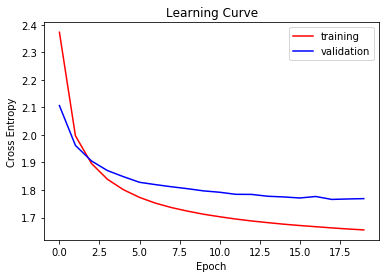

In [16]:
plt.plot(np.arange(20), loss_train, 'r', label='training')
plt.plot(np.arange(20), loss_test, 'b', label='validation')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.legend() 
plt.show()

In [10]:
prime_encode = np.array([vocab_to_int[c] for c in 'ROMEO'], dtype=np.int32)
prime_decode = [int_to_vocab[c] for c in prime_encode]

def softmax(vec):
    vec_=np.exp(vec)
    return vec_/sum(vec_)

In [ ]:
# by shooting
h_state=None
gen=[]
for i in range(20):
    if(i<1):
        x_onehot = prime_encode.reshape(-1)
        x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([5,1,68])
    b_x=Variable(torch.Tensor(x_onehot))
    b_x=b_x.cuda()
    prediction,h_state=rnn(b_x,h_state)
    #prediction=prediction.view(-1,68)
    h_state=Variable(h_state.data)
    h_state=h_state.cuda()
    prediction=Variable(prediction.data)
    prediction=prediction.cuda()
    #m=nn.Softmax()
    #prediction_w=m(prediction)
    word_encode=prediction.data.cpu().numpy()
    #tmp=np.argmax(word_encode.reshape(-1))
       # word_encode=word_encode.reshape(-1)
    word=[]
    
    for i in range(5):
        #tmp=np.argmax(word_encode[0,i,:])
        P=softmax(word_encode[i,0,:].reshape(-1))
        #print(P.shape)
        tmp=np.random.choice(68,1,p=P)
        word.append(tmp)
    #print(word)
    gen.append(word)
    word=np.array(word)
    x_onehot = word.reshape(-1)
    x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([5,1,68])
# # x_onehot = word.reshape(-1)
# # x_onehot = (np.arange(68) == x_onehot[:,None]).astype(np.float32).reshape([5,1,68])
# # b_x=Variable(torch.Tensor(x_onehot))
# # b_x=b_x.cuda()
# # prediction,h_state=rnn(b_x,h_state)

gen=np.array(gen)
gen=gen.reshape(-1)
print(gen.shape)
word = [int_to_vocab[c] for c in gen]
print(word)

